In [1]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
import geopandas as gp
import seaborn as sb
import os
import re
import scipy.stats as st
%matplotlib inline
plt.style.use('ggplot')

def abrev(i):
    return i[0:3] + i[3:].replace("a", "").replace("e", "").replace("i", "").replace("o", "").replace("u", "")[0:3]

In [2]:
plt.rcParams["figure.facecolor"] = "w"
pd.options.display.max_columns = 1000

In [5]:
os.chdir("../../../core")
import GT_helper_functions as hf
import GT_load_data as data

base_dir = "../../Outcome Measurement Data/MALARIA/"

In [6]:
# Esto no incluye toda las áreas del país. Sólo las áreas vistas en la base de datos de notifs.
notifs_das2depto = {
    "Escuintla": 5,
    "Alta Verapaz": 16,
    "Izabal" : 18,
    "Suchitepéquez" : 10,
    "Santa Rosa" : 6,
    "Retalhuleu" : 11,
    "Petén Norte" : 17,
    "Petén SurOccidental" : 17,
    "Huehuetenango" : 13,
    "Quiché" : 14,
    "Petén Sur Oriental" : 17,
    "Baja Verapaz" : 15,
    "Sololá" : 7,
    "Zacapa" : 18,
    "Ixcán" : 14,
    "San Marcos" : 12,
    "Chimaltenango" : 4,
    "Guatemala Central" : 1,
    "Guatemala Sur" : 1,
    "Ixil" : 14,
    "Jutiapa" : 22,
    "Chiquimula" : 20,
    "Ixcan" : 14,
    "El Progreso" : 2,
    "Guatemala Nororiental" : 1,
    "Quetzaltenango" : 9,
    "Jalapa": 21
}
code2depto = {
    5: "Escuintla",
    16:"Alta Verapaz",
    18: "Izabal",
    10: "Suchitepéquez",
    6: "Santa Rosa",
    11: "Retalhuleu",
    17: "Petén Norte",
    13: "Huehuetenango",
    14: "Quiché",
    15: "Baja Verapaz",
    7: "Sololá",
    18: "Zacapa",
    12: "San Marcos",
    4: "Chimaltenango",
    1: "Guatemala",
    22: "Jutiapa",
    20: "Chiquimula",
    2: "El Progreso",
    9: "Quetzaltenango",
    3: "Sacatepequez",
    21: "Jalapa"
}

In [7]:
deptos = data.deptosGTshp

In [8]:
data.munisGTshp.COD_DEPT__.value_counts().sort_index()

01    18
02     8
03    16
04    16
05    14
06    14
07    20
08     8
09    24
10    21
11     9
12    30
13    33
14    21
15     8
16    17
17    14
18     6
19    11
20    11
21     7
22    17
Name: COD_DEPT__, dtype: int64

In [9]:
bednets = pd.read_csv(base_dir + "GTM - Bednets Distr.csv", index_col = 0 )

/home/guillermo/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
notifs = pd.read_excel(base_dir + "Base de datos 2016 - 2018 NAD Consolidado 04.06.xlsx")


In [11]:
def clean(x):
    try: 
        return x.strip().lower()
    except:
        return np.NaN
notifs["deptocode"] = notifs.AREA.map(str.strip).map(notifs_das2depto.get)
notifs["GENERO"] = notifs["GENERO"].apply(clean)
notifs["Gender"] = notifs.GENERO.map(lambda x: "Male" if x == "m" else "Female" if x == "f" else np.NaN)
notifs["Year"] = notifs["FECHA TOMA DE MUESTRA"].map(lambda y: y.year)

In [18]:
bednets["Sustit"] = bednets.Sustit.map(lambda x: str(x).lower()[0] == "t")

In [42]:
bednets["uid"] = bednets.CodComun.astype(str) + bednets.CodBoleta.astype(str) +\
                    bednets.FechaEnt.astype(str)

In [43]:
uids = bednets.uid.value_counts()
uids[uids==1]

1601943.092202015-07-18 00:00:00     1
1801005.0530/04/2012                 1
1615120.0190482016-05-19 00:00:00    1
2005072.0232013-03-01 00:00:00       1
506065.01215017/08/2016              1
1607919.041752015-04-21 00:00:00     1
1215182.0174002016-09-07 00:00:00    1
2005001.0532013-05-17 00:00:00       1
1616655.0109942016-10-13 00:00:00    1
1807043.02924/01/2013                1
2009033.0232013-03-22 00:00:00       1
1001006.022012-12-10 00:00:00        1
1218060.0138832015-11-23 00:00:00    1
1101918.0223662018-01-30 00:00:00    1
1221029.0137442016-06-15 00:00:00    1
1904159.0202012-04-16 00:00:00       1
1904116.0372015-10-28 00:00:00       1
1710066.0127782016-08-09 00:00:00    1
1615067.0182742017-06-06 00:00:00    1
1606086.0141852015-12-29 00:00:00    1
1613513.0157352015-08-19 00:00:00    1
2001138.0292012-09-06 00:00:00       1
1501001.0732013-03-10 00:00:00       1
1807010.08920/08/2012                1
1601931.0390722018-03-14 00:00:00    1
1613068.096122015-04-29 0

In [48]:
bednetsYears = bednets[(bednets.Sustit==False)]\
    .groupby(["year", "CodDepto_e", "uid"]).Pabellones.first()\
    .reset_index().groupby(["year", "CodDepto_e"]).Pabellones.sum().unstack(0).fillna(0)
bednetsYears

year,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
CodDepto_e,,,,,,,
2.0,0.0,0.0,0.0,589.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,325.0,47.0,0.0,0.0
5.0,8765.0,2007.0,3631.0,10356.0,4723.0,255.0,591.0
6.0,0.0,0.0,781.0,1001.0,2042.0,0.0,0.0
7.0,0.0,0.0,0.0,845.0,219.0,57.0,0.0
9.0,0.0,0.0,0.0,2025.0,1505.0,49.0,149.0
10.0,596.0,565.0,0.0,397.0,529.0,6.0,0.0
11.0,3555.0,3137.0,0.0,5566.0,3939.0,0.0,2820.0
12.0,3288.0,1722.0,1.0,4438.0,3436.0,0.0,0.0


In [47]:
bednets.head()

,CodDepto_e,CodComun,CodBoleta,bd_year,FechaEnt,year,month,CodDepto_eD,Personas,MEmbarazada,Menores5a,Camas,Pabellones,Sustit,uid
0,11.0,1101002.0,17871,2015,2015-09-18 00:00:00,2015.0,9.0,11.0,8.0,0.0,1.0,6.0,6.0,False,1101002.0178712015-09-18 00:00:00
1,11.0,1101002.0,17871,2015,2015-09-18 00:00:00,2015.0,9.0,11.0,4.0,0.0,1.0,3.0,3.0,False,1101002.0178712015-09-18 00:00:00
2,11.0,1101002.0,17871,2015,2015-09-18 00:00:00,2015.0,9.0,11.0,5.0,0.0,1.0,2.0,2.0,False,1101002.0178712015-09-18 00:00:00
3,11.0,1101002.0,17871,2015,2015-09-18 00:00:00,2015.0,9.0,11.0,4.0,0.0,2.0,2.0,2.0,False,1101002.0178712015-09-18 00:00:00
4,11.0,1101002.0,17871,2015,2015-09-18 00:00:00,2015.0,9.0,11.0,1.0,0.0,0.0,1.0,1.0,False,1101002.0178712015-09-18 00:00:00


In [17]:
notifsYear = notifs.groupby(["Año", "deptocode"]).AREA.count().unstack(0).fillna(0)
notifsYear

Año,1899.0,2014.0,2015.0,2016.0,2017.0,2018.0
deptocode,,,,,,
1,0.0,0.0,3.0,11.0,13.0,0.0
2,0.0,0.0,2.0,0.0,2.0,0.0
4,0.0,0.0,12.0,3.0,2.0,0.0
5,5.0,1.0,3589.0,3194.0,2437.0,878.0
6,0.0,2.0,71.0,149.0,37.0,8.0
7,0.0,0.0,16.0,10.0,1.0,0.0
9,0.0,0.0,3.0,0.0,0.0,0.0
10,1.0,0.0,152.0,241.0,300.0,114.0
11,0.0,0.0,105.0,75.0,34.0,9.0


In [18]:
incidence = notifsYear.stack().rename("notifs").reset_index()
incidence["Population"] = incidence.apply(lambda x: 
                                      hf.GTDeptoPopulation(x.deptocode, x["Año"]), 1)

In [19]:
incidence["incidence"] = incidence.notifs/incidence.Population

In [20]:
incidence = incidence[incidence["Año"]>2014]
incidence = incidence.rename(columns={"Año":  "Year"}).pivot_table(values = "incidence", index = "deptocode",
                                           columns="Year")

/home/guillermo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


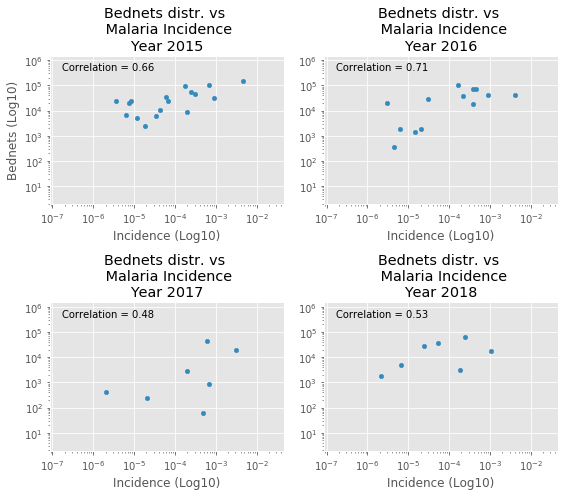

In [232]:
ymax = bednetsYears.max().max()
xmax = notifsYear.max().max()

def plotNotifsVsBednets(ax, year = 2015, ylabel = True):
    temp = pd.DataFrame(data = [bednetsYears[year], incidence[year]]).T.fillna(0)
    #temp = np.log10(temp)
    corr = np.round(np.log10(temp).corr().values[0][1], 2)
    temp.columns = ["Bednets (Log10)", "Incidence (Log10)"]
    ax.set_yscale("log", basey=10)
    ax.set_xscale("log", basex=10)
    temp.plot.scatter("Incidence (Log10)", "Bednets (Log10)",
                      title="Bednets distr. vs \n Malaria Incidence\nYear "+ str(year),
                          ax = ax)
    plt.text(0.05,0.9, "Correlation = "+str(corr), transform=ax.transAxes)
    if ylabel == False:
        ax.set_ylabel("")

mlp.rcParams['figure.figsize'] = [8.0, 7.0]
fig, axes = plt.subplots(2,2)
xlims = (np.min(list(filter(lambda x: x>0, incidence.values.flatten())))/10, 
                np.max(incidence.values.flatten())*10)
ylims = (np.min(list(filter(lambda x: x>0, bednetsYears.values.flatten())))/10, 
                np.max(bednetsYears.values.flatten())*10)
    
plotNotifsVsBednets(axes[0][0], 2015)
plotNotifsVsBednets(axes[0][1], 2016, False)
plotNotifsVsBednets(axes[1][0], 2017, False)
plotNotifsVsBednets(axes[1][1], 2018, False)
for row in axes:
    for ax in row:
        ax.set_xlim(xlims[0], xlims[1])
        ax.set_ylim(ylims[0], ylims[1])
plt.tight_layout()

/home/guillermo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


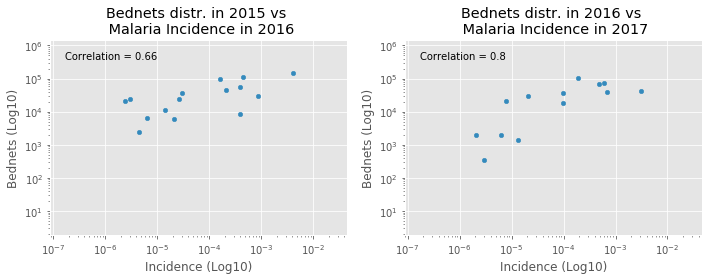

In [233]:
ymax = bednetsYears.max().max()
xmax = notifsYear.max().max()

def plotNotifsVsBednets(ax, year = 2015, ylabel = True):
    temp = pd.DataFrame(data = [bednetsYears[year-1], incidence[year]]).T.fillna(0)
    #temp = np.log10(temp)
    corr = np.round(np.log10(temp).corr().values[0][1], 2)
    temp.columns = ["Bednets (Log10)", "Incidence (Log10)"]
    ax.set_yscale("log", basey=10)
    ax.set_xscale("log", basex=10)
    temp.plot.scatter("Incidence (Log10)", "Bednets (Log10)",
                      title="Bednets distr. in "+str(year-1)+" vs \n Malaria Incidence in "+ str(year),
                          ax = ax)
    plt.text(0.05,0.9, "Correlation = "+str(corr), transform=ax.transAxes)
    if ylabel == False:
        ax.set_ylabel("")

mlp.rcParams['figure.figsize'] = [10.0, 4.0]
fig, axes = plt.subplots(1,2)
xlims = (np.min(list(filter(lambda x: x>0, incidence.values.flatten())))/10, 
                np.max(incidence.values.flatten())*10)
ylims = (np.min(list(filter(lambda x: x>0, bednetsYears.values.flatten())))/10, 
                np.max(bednetsYears.values.flatten())*10)
    

plotNotifsVsBednets(axes[0], 2016, True)
plotNotifsVsBednets(axes[1], 2017, True)
for ax in axes:
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
plt.tight_layout()

In [234]:
pblYears = bednetsYears.divide(1000).reset_index()\
                         .assign(deptocode=lambda x: (x.CodDepto_e * 100).astype(int).astype(str)\
                                 .map(lambda y: y if y != "100" else "101"))

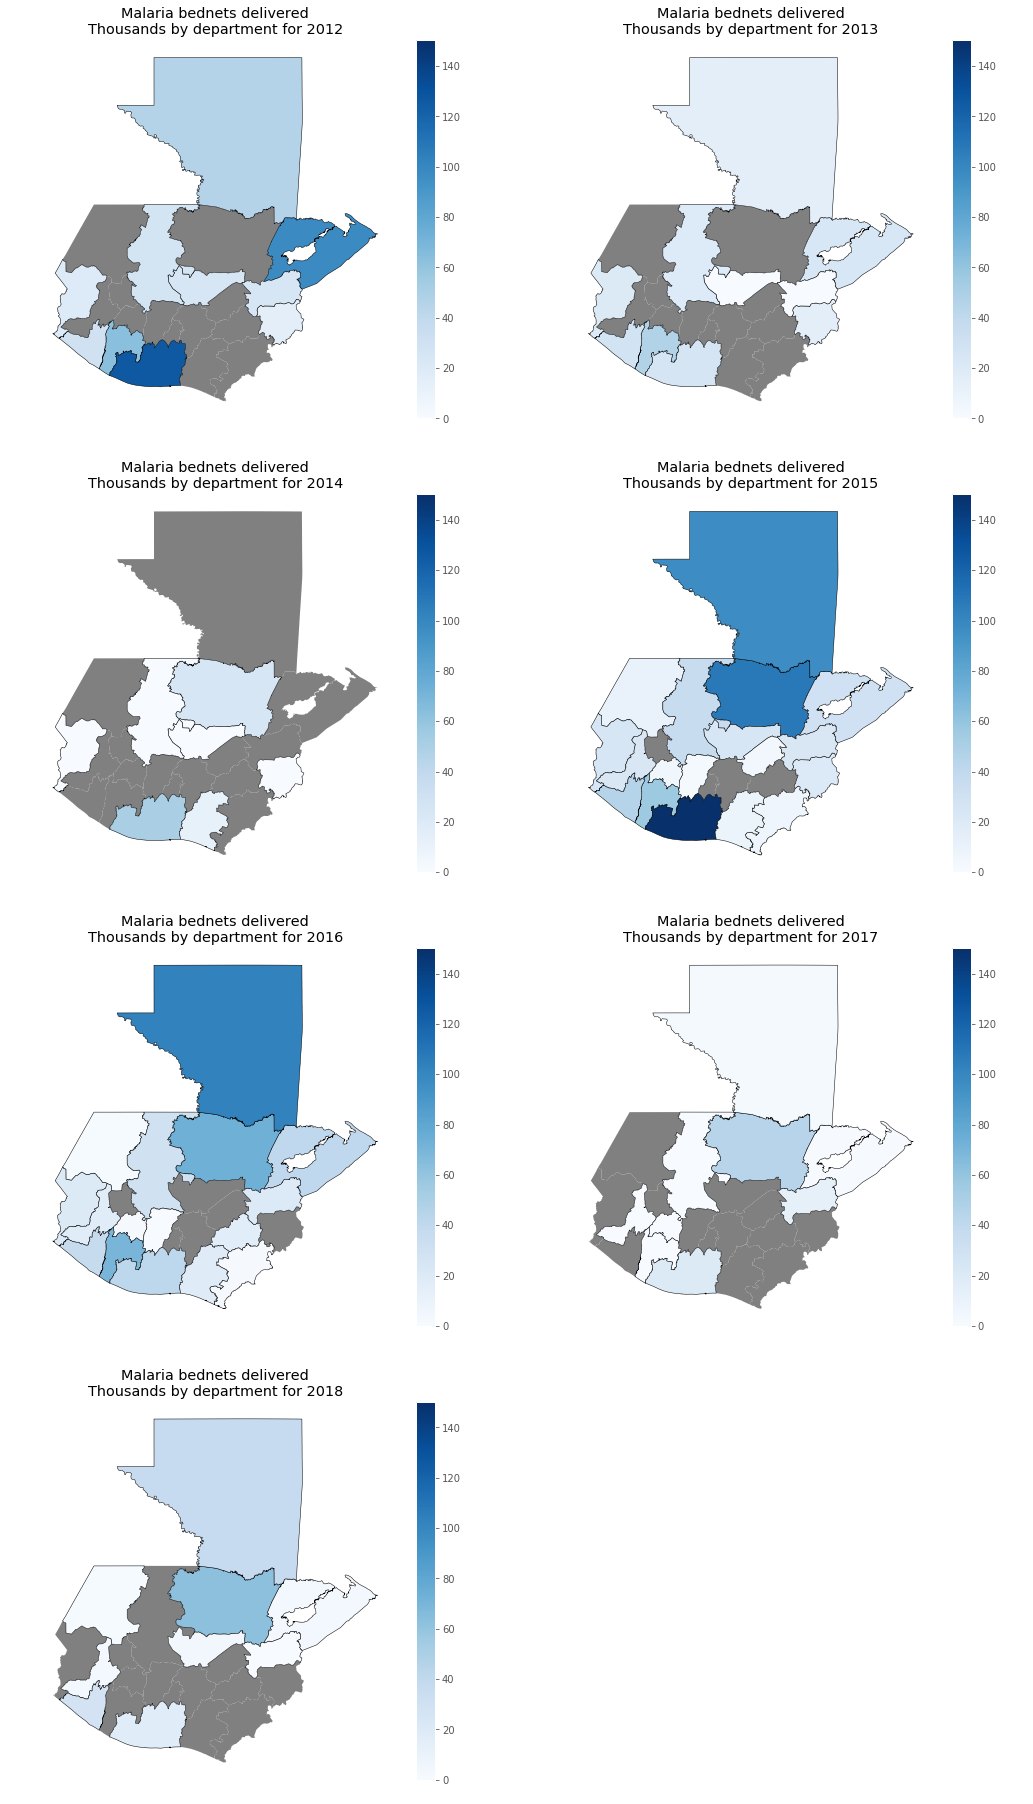

In [235]:
vmax = pblYears[list(range(2012,2018))].max().max()

side = 8
n = 7
vmin = 0
#vmax = 8
f, axes = plt.subplots(int(np.ceil(n/2)), 2, figsize=(side*2*1.1, side*np.ceil(n/2) ))
i = 2012
for row in axes:
    for ax in row:
        if i not in pblYears:
            ax.axis("off")
            continue
        temp3 = deptos.merge(pblYears[[i, "deptocode"]], 
                             left_on="CODIGO", right_on = "deptocode", how="left" ).fillna(0)
        temp3[temp3[i] == 0].plot(ax=ax, color="grey")
        if sum(temp3[i] > 0) > 0:
            temp3[temp3[i] > 0].plot(i, ax = ax, cmap = "Blues", 
                                             legend=True, edgecolor="black",
                                             vmin = vmin, vmax = vmax)
        ax.axis('off')
        ax.set_title("Malaria bednets delivered\nThousands by department for "+ str(i))
        i += 1

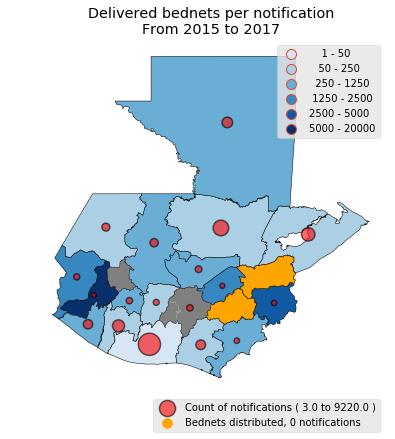

In [236]:
bn_over_notifs = bednetsYears[[2015,2016,2017]].sum(axis=1).divide(notifsYear[[2015,2016,2017]]\
                    .sum(axis=1).reindex(bednetsYears.index).fillna(0))\
                    .reset_index()
bn_over_notifs.columns = ["deptocode", "_i"]
bn_over_notifs["i"] = pd.cut(bn_over_notifs._i, bins = [0,1,50,250,1250,2500, 5000,20000,25000], 
                          labels = ["    0 - 1", "    1 - 50", "   50 - 250", "  250 - 1250", " 1250 - 2500", "2500 - 5000", 
                                    "5000 - 20000", "5000-25000"])
mlp.rcParams['figure.figsize'] = [6.2, 6.2]
temp = deptos.merge(bn_over_notifs.assign(deptocode=lambda x: (x.deptocode * 100).astype(int).astype(str)\
                                 .map(lambda y: y if y != "100" else "101")), 
                     left_on="CODIGO", right_on = "deptocode", how="left" )
ax = temp[temp.i.isna()].plot(color="grey") 
    
temp[temp.i.isna()==False].plot("i", ax=ax, vmin = -1,
                                legend=True, edgecolor="black", categorical = True, cmap = "Blues")
temp2 = deptos.merge(notifsYear[[2015,2016,2017]].sum(axis=1,skipna=True).rename("values").reset_index()\
                     .assign(deptocode=lambda x: (x.deptocode * 100).astype(int).astype(str)\
                     .map(lambda y: y if y != "100" else "101")), 
                     left_on="CODIGO", right_on = "deptocode", how="left" )\
    .assign(x = lambda row: row.geometry.centroid.x)\
    .assign(y = lambda row: row.geometry.centroid.y)
l1 = ax.get_legend()

plt.scatter(temp2.x, temp2.y, np.sqrt(temp2["values"])*5+15, c = "red", alpha=0.6, linewidths=1.5, edgecolors="black", 
            label = "Count of notifications ( " + str(temp2["values"].min()) + " to " + str(temp2["values"].max()) + " )")
if sum(np.isinf(temp._i)) > 0:
    # Departments with distr. of bednets but no registered Malaria cases.
    temp[np.isinf(temp._i)].plot(ax = ax, color="orange", edgecolors="black")  
plt.scatter([],[], 100, c="orange", label = "Bednets distributed, 0 notifications")
plt.legend(bbox_to_anchor=(1,0))
plt.gca().add_artist(l1)
plt.axis("off")
#ax.legend(ax.legend().get_ labels=["a", "n", "c", "d"])
plt.title("Delivered bednets per notification\nFrom 2015 to 2017")
plt.tight_layout()

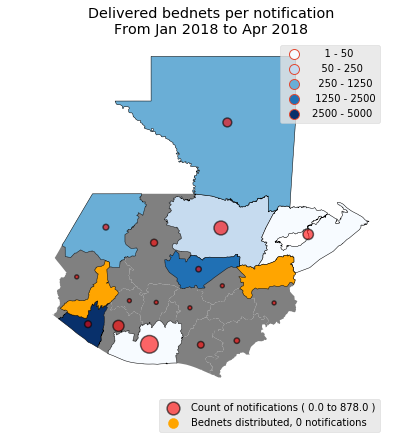

In [237]:
bn_over_notifs = bednetsYears[[2018]].sum(axis=1).divide(notifsYear[[2018]]\
                    .sum(axis=1).reindex(bednetsYears.index).fillna(0))\
                    .reset_index()
bn_over_notifs.columns = ["deptocode", "_i"]
bn_over_notifs["i"] = pd.cut(bn_over_notifs._i, bins = [0,1,50,250,1250,2500, 5000,20000,25000], 
                          labels = ["    0 - 1", "    1 - 50", "   50 - 250", "  250 - 1250", " 1250 - 2500", "2500 - 5000", 
                                    "5000 - 20000", "5000-25000"])
mlp.rcParams['figure.figsize'] = [6.2, 6.2]
temp = deptos.merge(bn_over_notifs.assign(deptocode=lambda x: (x.deptocode * 100).astype(int).astype(str)\
                                 .map(lambda y: y if y != "100" else "101")), 
                     left_on="CODIGO", right_on = "deptocode", how="left" )
ax = temp[temp.i.isna()].plot(color="grey") 
    
temp[temp.i.isna()==False].plot("i", ax=ax, vmin = 0,
                                legend=True, edgecolor="black", categorical = True, cmap = "Blues")
temp2 = deptos.merge(notifsYear[[2018]].sum(axis=1,skipna=True).rename("values").reset_index()\
                     .assign(deptocode=lambda x: (x.deptocode * 100).astype(int).astype(str)\
                     .map(lambda y: y if y != "100" else "101")), 
                     left_on="CODIGO", right_on = "deptocode", how="left" )\
    .assign(x = lambda row: row.geometry.centroid.x)\
    .assign(y = lambda row: row.geometry.centroid.y)
l1 = ax.get_legend()

plt.scatter(temp2.x, temp2.y, np.sqrt(temp2["values"])*10+15, c = "red", alpha=0.6, linewidths=1.5, edgecolors="black", 
            label = "Count of notifications ( " + str(temp2["values"].min()) + " to " + str(temp2["values"].max()) + " )")
if sum(np.isinf(temp._i)) > 0:
    # Departments with distr. of bednets but no registered Malaria cases.
    temp[np.isinf(temp._i)].plot(ax = ax, color="orange", edgecolors="black")  
plt.scatter([],[], 100, c="orange", label = "Bednets distributed, 0 notifications")
plt.legend(bbox_to_anchor=(1,0))
plt.gca().add_artist(l1)
plt.axis("off")
#ax.legend(ax.legend().get_ labels=["a", "n", "c", "d"])
plt.title("Delivered bednets per notification\nFrom Jan 2018 to Apr 2018")
plt.tight_layout()

(Propuesta de Jorge: Correlación entre diferencia de casos de 1 año con el anterior partido las bednets distribuidas en el año anterior. Para cada año)


In [554]:
def compareYears(ax, year, lagb = 1, lagn = 1):
    plt.xscale("log", basex=10)
    #plt.yscale("log", basey=10)
    notifsdiff = notifsYear[year].reindex(list(range(1,23))).sort_index().fillna(0).divide(\
                notifsYear[year-lagn].reindex(list(range(1,23))).sort_index().fillna(0) )
    bednetsprev = bednetsYears[year - lagb].reindex(list(range(1,23))).sort_index().fillna(0)
    plt.scatter(bednetsprev,  notifsdiff)
    #corr = np.corrcoef([bednetsprev, notifsdiff])
    #plt.text(0.05,0.9, "Correlation = "+str(corr[1][0]), transform=ax.transAxes)
    plt.ylabel("Relation of notifications \nbetween years \n " + str(year) + "/"+ str(year-lagn) )
    for b, n, depto in zip(bednetsprev,  notifsdiff, bednetsprev.index):
        if (np.isnan(n) ==False) &\
            (np.isnan(b) ==False) & (np.isinf(n) == False) & (b>0):
            try:
                plt.text(b, n, str(depto), fontsize=8)
            except: 
                pass

    plt.xlabel("Bednets in "+ str(year-lagb) )
    #plt.ylim(0.1, 100)
    plt.xlim(0.5, 100*bednetsprev.max())
    return notifsdiff, bednetsprev

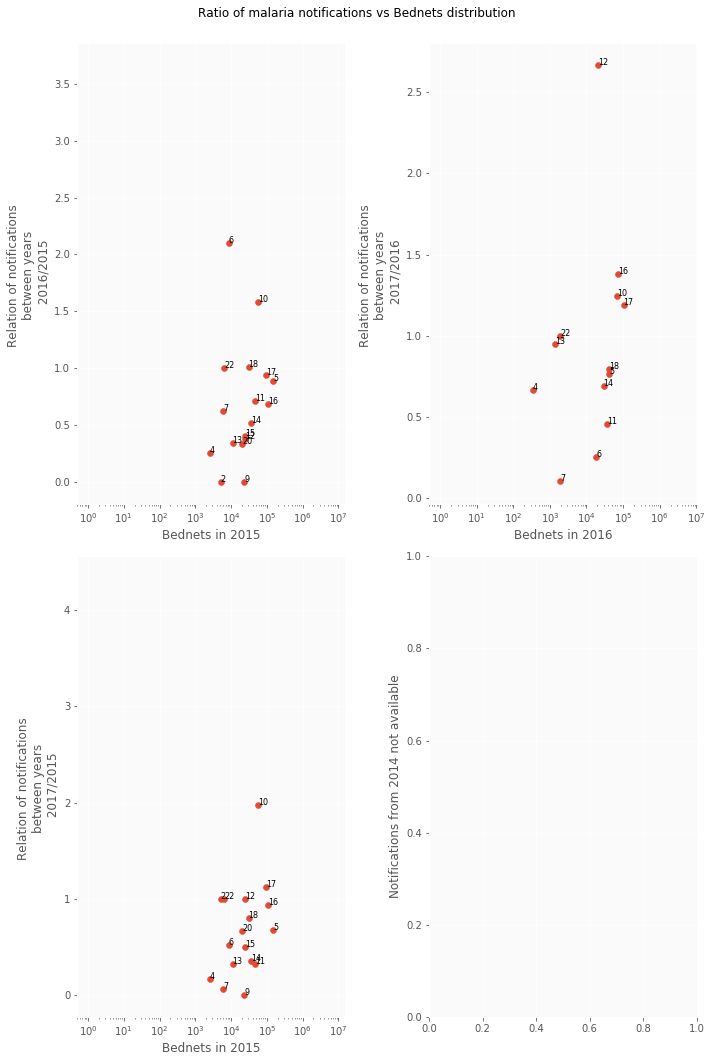

In [558]:
mlp.rcParams['figure.figsize'] = [10, 15]
ax = plt.subplot(2,2,1)
compareYears(ax, 2016, lagb = 1, lagn = 1)
ax = plt.subplot(2,2,2)
data = compareYears(ax, 2017, lagb = 1, lagn = 1)
ax = plt.subplot(2,2,3)
data = compareYears(ax, 2017, lagb = 2, lagn = 2)
ax = plt.subplot(2,2,4)
plt.ylabel("Notifications from 2014 not available")
plt.suptitle("Ratio of malaria notifications vs Bednets distribution")
plt.tight_layout(rect=(0, 0, 1, 0.96))

In [200]:
notifs.Year.value_counts()

2015.0    5411
2016.0    4800
2017.0    4089
2018.0    1463
2014.0       4
Name: Year, dtype: int64

In [56]:
def age_groups(x):
    if x < 40:
        x = np.floor(x/5)*5
        return str(int(x)) + " - " + str(int(x+5))  
    elif x < 60:
        return "40 - 60"
    else:
        return "60 - 100"

In [57]:
d = notifs[(notifs.GENERO!="d") & (notifs.EDAD < 100) & (notifs.deptocode==5)
          ]\
        .assign(AgeGroup = lambda x: x.EDAD.map(age_groups)).groupby(["AgeGroup","GENERO", "deptocode"]).deptocode.count()\
    .rename("Cases").reset_index()

/home/guillermo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


Text(0.5,1,'Malaria - Gender differences by age and department\nNotifications from 2015 to Apr 2018')

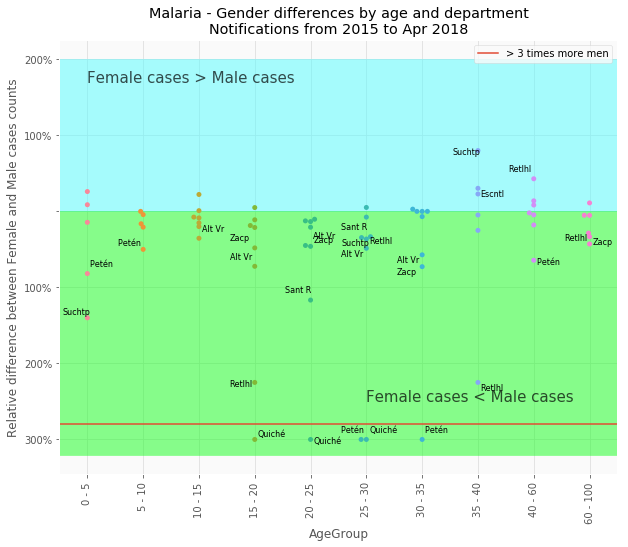

In [111]:
d2 = notifs[(notifs.GENERO!="d") & (notifs.EDAD < 100)
          ]\
        .assign(AgeGroup = lambda x: x.EDAD.map(age_groups)).groupby(["AgeGroup","GENERO", "deptocode"]).deptocode.count()\
    .rename("Cases").unstack(1).fillna(0)
mlp.rcParams['figure.figsize'] = [10, 8]
d = d2[["m", "f"]].apply(lambda x: \
              ((-(x.m-x.f)/x.f if x.m>x.f else (x.f-x.m)/x.m) if x.m+x.f > 15 else np.NaN),1)\
    .apply(lambda x: 0 if np.isinf(x) else -3 if x<-3 else x)\
    .rename("Female-Male").reset_index()
order = [str(x) + " - " + str(x+5) for x in range(0,40, 5)] + ["40 - 60", "60 - 100"]
ageg2x = dict(zip(order, range(0,len(order))))
sb.swarmplot("AgeGroup", "Female-Male", data = d, order=order)
for i, row in d.sort_values("Female-Male").iterrows():
    if abs(row["Female-Male"])>0.3:
        plt.text(ageg2x[row.AgeGroup]+ (-0.45 if np.random.choice([True,False]) else 0.05), 
                 row["Female-Male"]+np.random.choice([0.1,-0.1,0.05,-0.05]), abrev(code2depto[row.deptocode]), fontsize=8)
plt.fill_between([-1,10], [0, 0], [2,2], color="#52fcff", alpha = 0.5)
plt.fill_between([-1,10], [0, 0], [-3.2,-3.2], color="#14ff1c", alpha = 0.5)
plt.grid(True, "both", color="#dedede")
plt.rcParams['axes.facecolor'] = '#fafafa'
plt.xticks(rotation=90)
plt.axhline(-2.8, label="> 3 times more men")
plt.legend()
plt.yticks([2,1,0,-1,-2,-3], ["200%", "100%", "", "100%", "200%", "300%"])
plt.ylabel("Relative difference between Female and Male cases counts")
plt.text(0, 1.7, "Female cases > Male cases", fontsize=15, alpha=0.7)
plt.text(5, -2.5, "Female cases < Male cases", fontsize=15, alpha=0.7)
plt.title("Malaria - Gender differences by age and department\nNotifications from 2015 to Apr 2018")

In [84]:
notifs[(notifs.GENERO!="d") & (notifs.EDAD < 100) & (notifs.deptocode==14)
          ]\
        .assign(AgeGroup = lambda x: x.EDAD.map(age_groups)).groupby(["AgeGroup","GENERO", "deptocode"]).deptocode.count()\
    .rename("Cases").unstack(1).fillna(0)

,GENERO,f,m
AgeGroup,deptocode,,
0 - 5,14,1.0,2.0
10 - 15,14,3.0,6.0
15 - 20,14,3.0,13.0
20 - 25,14,3.0,23.0
25 - 30,14,3.0,23.0
30 - 35,14,0.0,18.0
35 - 40,14,3.0,7.0
40 - 60,14,2.0,13.0
5 - 10,14,2.0,2.0


Text(0.5,1,'Malaria: \nPercentage of delays that are less than 3 days long')

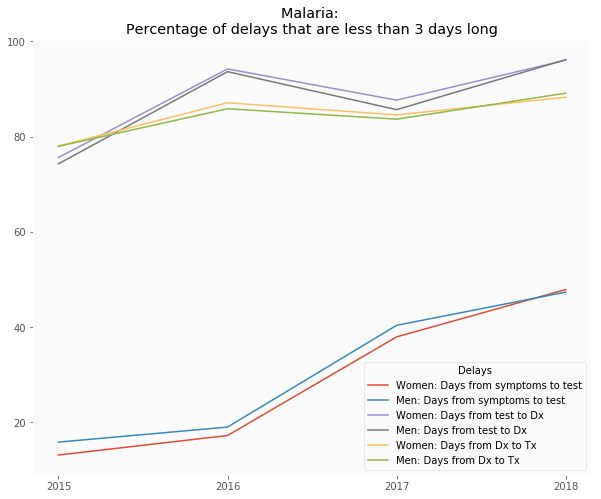

In [112]:
d = notifs[(notifs.GENERO!="d") & (notifs.EDAD < 100) & (notifs.Year > 2014)
          ].groupby(["Gender", "Year"]).agg({
    'Sintytom': lambda x: 100*sum(x<=3)/len(x), 
    'tomydiag': lambda x: 100*sum(x<=3)/len(x), 
    'diagytrat': lambda x: 100*sum(x<=3)/len(x)
}).unstack(0)
plt.plot(d) 
plt.legend(labels=["Women: Days from symptoms to test", 
                   "Men: Days from symptoms to test", 
                   "Women: Days from test to Dx",
                   "Men: Days from test to Dx",
                   "Women: Days from Dx to Tx",
                   "Men: Days from Dx to Tx"], title="Delays")
plt.grid()
plt.xticks([2015, 2016, 2017, 2018], [2015,2016,2017,2018])
plt.title("Malaria: \nPercentage of delays that are less than 3 days long")

In [66]:
d = notifs[(notifs.EDAD < 100) & (notifs.Year > 2014)
          ].groupby(["deptocode", "Year"]).agg({
    'Sintytom': lambda x: (str(round(100*sum(x<=3))/len(x)) + ", " + str(len(x))), 
    'tomydiag': lambda x: (str(round(100*sum(x<=3))/len(x)) + ", " + str(len(x))), 
    'diagytrat': lambda x: (str(round(100*sum(x<=3))/len(x)) + ", " + str(len(x)))
})
d.unstack(0)

Sintytom                                  \
deptocode                      1        2                      4    
Year                                                                
2015.0                     0.0, 3  50.0, 2  36.36363636363637, 11   
2016.0     27.272727272727273, 11     None  33.333333333333336, 3   
2017.0     7.6923076923076925, 13   0.0, 2                 0.0, 2   
2018.0                       None     None                   None   

                                                                         \
deptocode                        5                        6          7    
Year                                                                      
2015.0     0.5304299274148521, 3582   16.901408450704224, 71  18.75, 16   
2016.0     11.466165413533835, 3192  25.503355704697988, 149    0.0, 10   
2017.0      37.28952772073922, 2435    8.108108108108109, 37     0.0, 1   
2018.0       44.07744874715262, 878                   0.0, 8       None   

                                                           \
deptocode                     9                        10   
Year                                                        
2015.0     33.333333333333336, 3  20.394736842105264, 152   
2016.0                      None  19.502074688796682, 241   
2017.0                      None                31.0, 300   
2018.0                      None   31.57894736842105, 114   

                                                           \
deptocode                       11                     12   
Year                                                        
2015.0     18.095238095238095, 105                 0.0, 8   
2016.0      18.666666666666668, 75               100.0, 3   
2017.0      14.705882352941176, 34  14.285714285714286, 7   
2018.0                      0.0, 9                   None   

                                                                     \
deptocode                      13                      14        15   
Year                                                                  
2015.0     21.818181818181817, 55  14.285714285714286, 63  25.0, 20   
2016.0      21.05263157894737, 19              15.625, 32    0.0, 8   
2017.0      11.11111111111111, 18  13.636363636363637, 22  30.0, 10   
2018.0      33.333333333333336, 3  18.181818181818183, 11  100.0, 2   

                                                            \
deptocode                      16                       17   
Year                                                         
2015.0      63.1578947368421, 798   44.71544715447155, 123   
2016.0     46.02587800369686, 541  33.333333333333336, 114   
2017.0                  54.8, 750   43.47826086956522, 138   
2018.0     73.54838709677419, 310    30.76923076923077, 39   

                                                                     \
deptocode                       18                     20        22   
Year                                                                  
2015.0     31.202046035805626, 391  33.333333333333336, 3  100.0, 1   
2016.0     28.426395939086294, 394                 0.0, 1    0.0, 3   
2017.0     36.217948717948715, 312                 0.0, 2    0.0, 3   
2018.0       32.55813953488372, 86                   None    0.0, 2   

                        tomydiag                       \
deptocode                     1         2          4    
Year                                                    
2015.0                  100.0, 3  100.0, 2  100.0, 11   
2016.0     81.81818181818181, 11      None   100.0, 3   
2017.0                 100.0, 13  100.0, 2   100.0, 2   
2018.0                      None      None       None   

                                                                       \
deptocode                       5                       6          7    
Year                                                                    
2015.0     69.87716359575656, 3582   98.59154929577464, 71  100.0, 16   
2016.0     99.56140350877193, 3192  

In [132]:

mlp.rcParams['figure.figsize'] = [7, 3]
def delayPlot(column):
    q1,q2,q3 = (
     np.nanpercentile(notifs[column][notifs[column]>3],25),
     np.nanpercentile(notifs[column][notifs[column]>3],50),
     np.nanpercentile(notifs[column][notifs[column]>3],75))
    iqr = q3-q1
    m = notifs[column][notifs[column]>3].mean()
    ax = plt.subplot(1,1,1)
    ungrouped = notifs[(notifs.GENERO!="d") & (notifs[column]>3) & (np.abs(notifs[column]-m)<(1.5*iqr)) & 
           (notifs.EDAD < 100) & (notifs.Year > 2014)]
    grouped = ungrouped.groupby(["Year", "GENERO"])[column]
    #grouped.count().unstack(1).plot(ax=ax)
    #plt.ylabel("Number of cases")
    #plt.legend().remove()
    #ax = plt.subplot(2,1,2)
    means = grouped.mean().reset_index() #.unstack(1)
    ses =  grouped.apply(st.sem).reset_index()
    #means.unstack(1).plot(ax=ax)
    plt.errorbar(means[means.GENERO=="f"].Year, means[means.GENERO=="f"][column],
                 yerr = ses[ses.GENERO=="f"][column], capsize=2, color="#CC3333", label="f")
    plt.errorbar(means[means.GENERO=="m"].Year+0.01, means[means.GENERO=="m"][column],
                 yerr = ses[ses.GENERO=="m"][column], capsize=2, color="#5373FF", label="m")
    plt.legend(title="Gender")
    plt.xticks([2015,2016,2017,2018])
    plt.ylabel("Mean days delay")
    plt.tight_layout(rect=(0,0,1,0.9))
    return grouped

Text(0.5,0.98,'Average days between Symptoms and Test \nfor delays > 3 days')

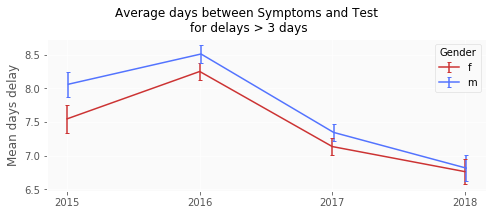

In [133]:
g = delayPlot("Sintytom")
plt.suptitle("Average days between Symptoms and Test \nfor delays > 3 days")

Text(0.5,0.98,'Average days between Test and Dx \nfor delays > 3 days')

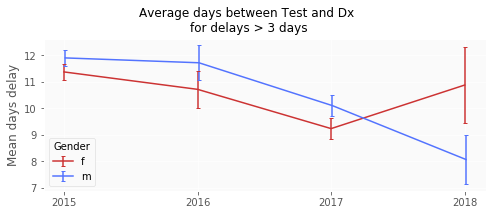

In [134]:
g = delayPlot("tomydiag")
plt.suptitle("Average days between Test and Dx \nfor delays > 3 days")

Text(0.5,0.98,'Average days between Dx and Tx \nfor delays > 3 days')

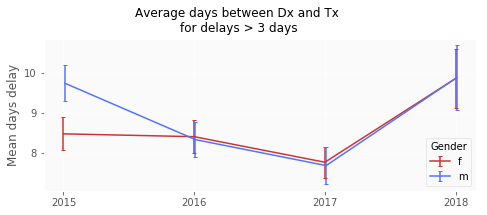

In [135]:
delayPlot("diagytrat")
plt.suptitle("Average days between Dx and Tx \nfor delays > 3 days")

# Analysis of Malaria bednets effect on incidence 

### Prepare lags

In [447]:
g.sum().sum()

40886.0

In [240]:
notifsSemester = notifs[notifs.Year > 2014].assign(Semester = lambda x: \
                                      x["FECHA TOMA DE MUESTRA"].map(lambda y: (2 if y.month>6 else 1)))\
    .groupby(["deptocode", "Year", "Semester"]).Year.count().unstack([1,2], fill_value = 0).stack([0,1]).rename("Notifs").reset_index()
notifsSemester["semindex"] = 2*(notifsSemester.Year - 2014) + notifsSemester.Semester

In [241]:
bednetsSemester = bednets[((bednets.year==2018) & (bednets.month >= 7)) == False]\
        .assign(Semester = lambda x: x.month.map(lambda y: 2 if y > 6 else 1))\
        .groupby(["year", "Semester", "CodDepto_e"])\
         .Pabellones.sum().unstack([0,1], fill_value = 0).stack([0,1]).reset_index()
bednetsSemester["semindex"] = 2*(bednetsSemester.year - 2014) + bednetsSemester.Semester

In [242]:
def lagBednet(i):
    def lagCalc(x):
        bednetsLag = bednetsSemester[(bednetsSemester.CodDepto_e == x.deptocode) &(bednetsSemester.semindex == (x.semindex - i))][[0]]
        bednetsLag2 = bednetsSemester[(bednetsSemester.CodDepto_e == x.deptocode) &(bednetsSemester.semindex == (x.semindex - i - 1))][[0]]
        
        if len(bednetsLag) == 1:
            return bednetsLag2.values[0][0]+bednetsLag.values[0][0]
        else:
            return 0
    return lagCalc

for i in range(1,5):
    notifsSemester["bednetsLagSem_"+str(i)] = notifsSemester.apply(lagBednet(i), axis = 1)

In [243]:
def lagNotifs(i):
    def lagCalc(x):
        notifsLag = notifsSemester[(notifsSemester.deptocode == x.deptocode) &(notifsSemester.semindex == (x.semindex - i))].Notifs
        if len(notifsLag) == 1:
            return notifsLag.values[0]
        else:
            return 0
    return lagCalc

for i in range(1,5):
    notifsSemester["notifsLagSem_"+str(i)] = notifsSemester.apply(lagNotifs(i), axis = 1)

### Analysis

In [365]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [380]:
notifsSemester["Year_n"] = (notifsSemester.Year - notifsSemester.Year.mean()) #/notifsSemester.Year.std()
for i in range(1,5):
    notifsSemester["notifsLagSem_"+str(i)+"_n"] = (notifsSemester["notifsLagSem_"+str(i)] -\
                                                   notifsSemester["notifsLagSem_"+str(i)].mean())/notifsSemester["notifsLagSem_"+str(i)].std()
    notifsSemester["bednetsLagSem_"+str(i)+"_n"] = \
        (notifsSemester["bednetsLagSem_"+str(i)] -\
            notifsSemester["bednetsLagSem_"+str(i)].mean())/notifsSemester["bednetsLagSem_"+str(i)].std()

In [244]:
notifsSemester.to_csv("/tmp/malaria_gee.csv")

In [394]:
fam = sm.families.Poisson()
mod = smf.glm(formula = "Notifs ~ 1 + C(deptocode) + C(Semester) + " + 
                  #" (notifsLagSem_1_n + notifsLagSem_2_n) + " + 
                  " (bednetsLagSem_1_n + bednetsLagSem_2_n +bednetsLagSem_3_n + bednetsLagSem_4_n)", 
              data = notifsSemester[(notifsSemester.semindex.isin([3,4,5,6,7,8]))], #.assign(Notifs = lambda x: x.Notifs + 1), 
              family=fam)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Notifs   No. Observations:                  108
Model:                            GLM   Df Residuals:                       85
Model Family:                 Poisson   Df Model:                           22
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1120.2
Date:                Mon, 08 Oct 2018   Deviance:                       1787.8
Time:                        12:49:20   Pearson chi2:                 1.97e+03
No. Iterations:                     9   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.6396      0.193      8.505      0.000       1.262       2.017
C(deptocode)[T.2]     -1.9067      0.536     -3.559      0.000      -2.957      -0.857
C(deptocode)[T.4]     -0.5209      0.315     -1.651      0.099      -1.139       0.097
C(deptocode)[T.5]      6.1111      0.194     31.454      0.000       5.730       6.492
C(deptocode)[T.6]      2.2717      0.202     11.228      0.000       1.875       2.668
C(deptocode)[T.7]      0.0107      0.272      0.039      0.969      -0.523       0.544
C(deptocode)[T.9]     -2.1736      0.609     -3.572      0.000      -3.366      -0.981
C(deptocode)[T.10]     3.3520      0.197     17.036      0.000       2.966       3.738
C(deptocode)[T.11]     2.1120      0.204     10.339      0.000       1.712       2.512
C(deptocode)[T.12]    -0.3687      0.304     -1.211      0.226      -0.965       0.228
C(deptocode)[T.13]     1.2446      0.219      5.686      0.000       0.816       1.674
C(deptocode)[T.14]     1.5316      0.214      7.170      0.000       1.113       1.950
C(deptocode)[T.15]     0.3641      0.252      1.446      0.148      -0.129       0.857
C(deptocode)[T.16]     4.6538      0.195     23.815      0.000       4.271       5.037
C(deptocode)[T.17]     2.8697      0.200     14.324      0.000       2.477       3.262
C(deptocode)[T.18]     3.7678      0.195     19.287      0.000       3.385       4.151
C(deptocode)[T.20]    -1.4928      0.451     -3.307      0.001      -2.377      -0.608
C(deptocode)[T.22]    -1.2121      0.403     -3.011      0.003      -2.001      -0.423
C(Semester)[T.2]      -0.4610      0.019    -24.125      0.000      -0.498      -0.424
bednetsLagSem_1_n     -0.0270      0.012     -2.326      0.020      -0.050      -0.004
bednetsLagSem_2_n     -0.0249      0.018     -1.395      0.163      -0.060       0.010
bednetsLagSem_3_n     -0.1261      0.020     -6.467      0.000      -0.164      -0.088
bednetsLagSem_4_n      0.0524      0.015      3.596      0.000       0.024       0.081
======================================================================================
"""

In [211]:
#notifsSemester["bednetsLagSem_1"] = np.log(notifsSemester.bednetsLagSem_1+1)

In [412]:
fam = sm.families.Gaussian()
ind = sm.cov_struct.Exchangeable()
mod = smf.gee(formula = "np.log(Notifs+1) ~ 1+ Year_n + C(Semester) + " + 
                  " (notifsLagSem_1 + notifsLagSem_2  + notifsLagSem_3)*" + 
                  " (bednetsLagSem_1 + bednetsLagSem_2 + bednetsLagSem_3)", 
              data = notifsSemester[(notifsSemester.semindex.isin([5,6,7,8]))], #.assign(Notifs = lambda x: x.Notifs + 1), 
              groups = "deptocode", 
              family=fam, cov_struct=ind)
res = mod.fit()
res.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/generalized_estimating_equations.py:1128: IterationLimitWarning: Iteration limit reached prior to convergence
  IterationLimitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:          np.log(Notifs + 1)   No. Observations:                   72
Model:                                 GEE   No. clusters:                       18
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                   4
Family:                           Gaussian   Mean cluster size:                 4.0
Dependence structure:         Exchangeable   Num. iterations:                    60
Date:                     Mon, 08 Oct 2018   Scale:                           0.897
Covariance type:                    robust   Time:                         15:58:22
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.2731      0.311      4.100      0.000       0.664       1.882
C(Semester)[T.2]                  -0.3023      0.122     -2.480      0.013      -0.541      -0.063
Year_n                            -0.1218      0.195     -0.624      0.533      -0.504       0.261
notifsLagSem_1                     0.0087      0.001      6.146      0.000       0.006       0.011
notifsLagSem_2                     0.0096      0.002      4.343      0.000       0.005       0.014
notifsLagSem_3                    -0.0005      0.002     -0.224      0.823      -0.005       0.004
bednetsLagSem_1                 1.052e-05   2.53e-06      4.152      0.000    5.55e-06    1.55e-05
bednetsLagSem_2                -6.794e-06   1.68e-06     -4.053      0.000   -1.01e-05   -3.51e-06
bednetsLagSem_3                 1.158e-05   2.04e-06      5.685      0.000    7.59e-06    1.56e-05
notifsLagSem_1:bednetsLagSem_1   5.53e-09   1.19e-08      0.465      0.642   -1.78e-08    2.88e-08
notifsLagSem_1:bednetsLagSem_2 -2.922e-08   2.33e-08     -1.255      0.209   -7.49e-08    1.64e-08
notifsLagSem_1:bednetsLagSem_3 -2.967e-08   2.79e-08     -1.062      0.288   -8.44e-08    2.51e-08
notifsLagSem_2:bednetsLagSem_1 -2.014e-08   8.15e-09     -2.473      0.013   -3.61e-08   -4.18e-09
notifsLagSem_2:bednetsLagSem_2 -9.336e-09   2.32e-08     -0.402      0.688   -5.49e-08    3.62e-08
notifsLagSem_2:bednetsLagSem_3  2.436e-09   1.04e-08      0.234      0.815    -1.8e-08    2.28e-08
notifsLagSem_3:bednetsLagSem_1  5.635e-09   1.54e-08      0.365      0.715   -2.46e-08    3.59e-08
notifsLagSem_3:bednetsLagSem_2  1.938e-08      2e-08      0.967      0.334   -1.99e-08    5.87e-08
notifsLagSem_3:bednetsLagSem_3 -1.067e-08   2.33e-08     -0.458      0.647   -5.64e-08     3.5e-08
==============================================================================
Skew:                          0.2683   Kurtosis:                       0.1926
Centered skew:                 0.6109   Centered kurtosis:              1.6981
==============================================================================
"""

In [584]:
mlp.rcParams['figure.figsize'] = [8, 8]

def mapMalaria(year, ax):
    temp = deptos.merge((np.log10(incidence[year]*100000)).reset_index().assign(i=lambda x: x[year], deptocode=lambda x: (x.deptocode * 100).astype(int).astype(str)\
                                     .map(lambda y: y if y != "100" else "101")), 
                         left_on="CODIGO", right_on = "deptocode", how="left" )
    temp[temp.i.isna() | (temp.i==0) | (np.isinf(temp.i))].plot(color="grey", ax= ax) 

    temp[(temp.i.isna()==False) & (temp.i> -np.Inf)].plot("i", ax=ax, vmin = 0, vmax = temp.i.max(),
                                    legend=False, edgecolor="black", cmap = "Blues")
    temp2 = deptos.merge(bednetsYears[[year+1]].sum(axis=1,skipna=True).rename("values").reset_index()\
                         .assign(deptocode=lambda x: (x.CodDepto_e * 100).astype(int).astype(str)\
                         .map(lambda y: y if y != "100" else "101")), 
                         left_on="CODIGO", right_on = "deptocode", how="left" )\
        .assign(x = lambda row: row.geometry.centroid.x)\
        .assign(y = lambda row: row.geometry.centroid.y)
    l1 = ax.get_legend()
    for i, depto in deptos.iterrows():
        plt.text(depto.geometry.centroid.x, (depto.geometry.bounds[3]+1.5*depto.geometry.centroid.y)/2.5, 
                 abrev(depto.DEPARTAMEN), color="black",
                 horizontalalignment='center', alpha=0.8, fontsize=9)

    plt.scatter(temp2.x, temp2.y, np.sqrt(temp2["values"])*3+25, c = "red", alpha=0.6, linewidths=1.5, edgecolors="black", 
                label = "Distributed bednets ( " + str(temp2["values"].min()) + " to " + str(temp2["values"].max()) + " )")
    cmap = plt.get_cmap('Blues')
    vmax = temp.i.max()
    norm = mlp.colors.Normalize(vmin=0,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink = 0.5, ticks=np.linspace(0,vmax,10))
    cbar.set_ticklabels([int(np.round(10**x)) for x in np.linspace(0,vmax,10)])
    cbar.set_label("Incidence per 100K habitants")
    plt.legend(bbox_to_anchor=(1,0))
    #plt.gca().add_artist(l1)
    plt.axis("off")
    #ax.legend(ax.legend().get_ labels=["a", "n", "c", "d"])
    plt.title("Malaria incidence per 100K people in "+str(year)+"\n vs distributed bednets in "+str(year+1)+" \n")
    plt.tight_layout()


/home/guillermo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


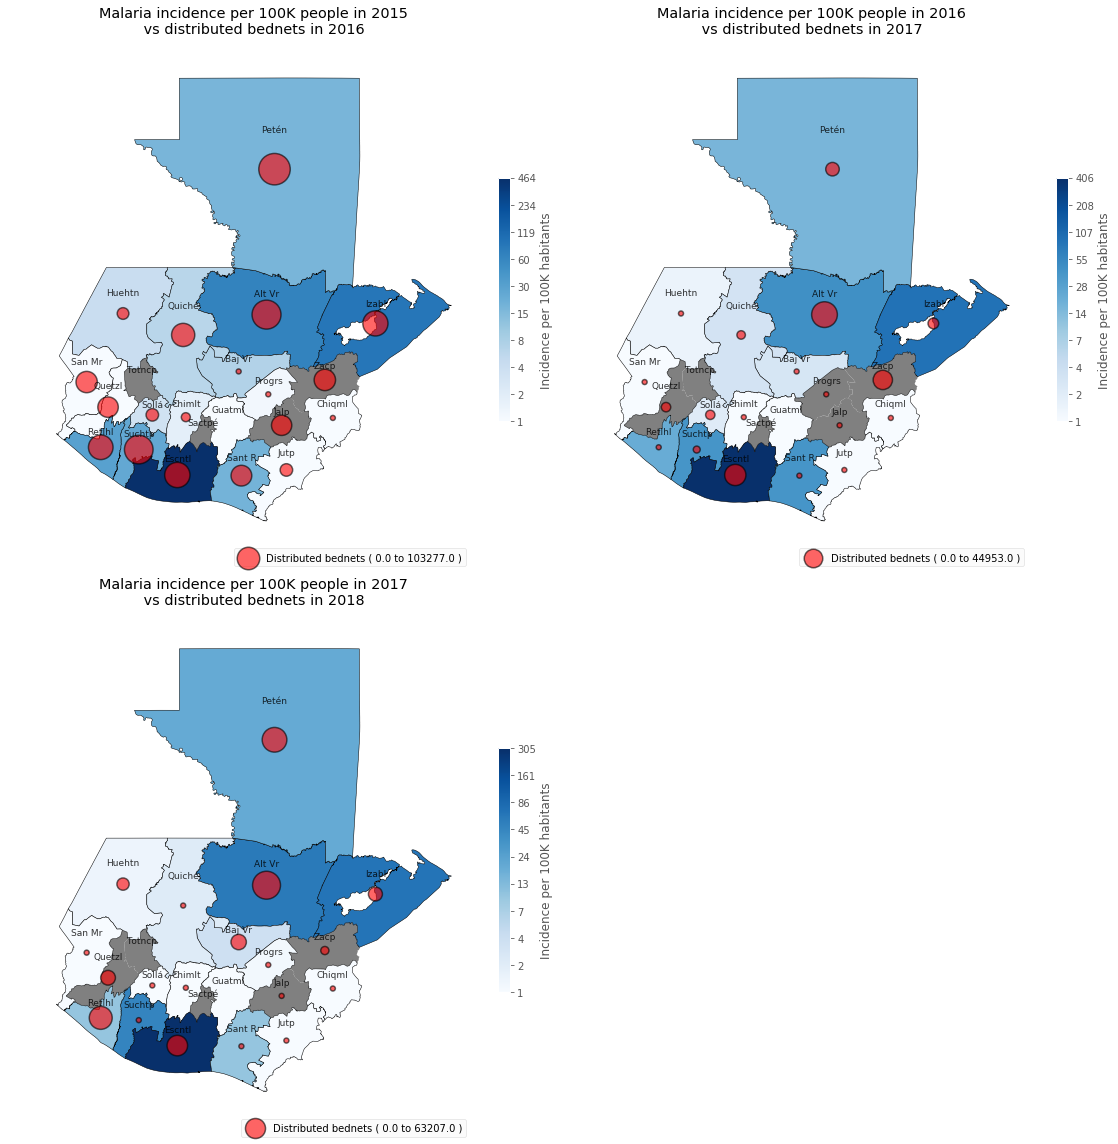

In [585]:
mlp.rcParams["figure.figsize"] = (16,16)
ax = plt.subplot(2,2,1)
mapMalaria(2015, ax)
ax = plt.subplot(2,2,2)

mapMalaria(2016, ax)
ax = plt.subplot(2,2,3)
mapMalaria(2017, ax)
#ax = plt.subplot(2,2,4)
#mapMalaria(2018, ax)

In [224]:
bednetsYears

year,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
CodDepto_e,,,,,,,
2.0,0.0,0.0,0.0,5137.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,5000.0,346.0,0.0,0.0
5.0,315925.0,63305.0,127630.0,375675.0,125124.0,40000.0,17309.0
6.0,0.0,0.0,11907.0,17330.0,18250.0,0.0,0.0
7.0,0.0,0.0,0.0,18210.0,3872.0,422.0,0.0
9.0,0.0,0.0,0.0,23337.0,34497.0,446.0,4090.0
10.0,191385.0,142365.0,0.0,170166.0,139934.0,59.0,0.0
11.0,29615.0,28312.0,0.0,45595.0,74900.0,0.0,27937.0
12.0,38974.0,40882.0,100.0,49954.0,20518.0,0.0,0.0


In [21]:
peten = notifs[notifs.deptocode==17].DISTRITO.value_counts()

In [195]:
import difflib
def simplifyName(i):
    i = str(i).lower().strip()
    for v, vt in zip("aeiou", "áéíóú"):
        i = i.replace(vt, v)
    return i
def nombreToCode(i, depto):
    i = simplifyName(i)
    subset = data.munisGT[(data.munisGT.deptocode==depto)]
    ratios = subset.apply(lambda j: \
                   difflib.SequenceMatcher(None, i, j.simplifiedName).real_quick_ratio(),
              1)
    if len(ratios)>0:
        return subset.loc[ratios.idxmax()].municode
    return np.NaN

In [196]:
data.munisGT["simplifiedName"] = data.munisGT.name.map(simplifyName)

In [197]:
list(zip(peten.index, peten.index.map(lambda x: nombreToCode(x, 17))))

[('SAN JOSE', 1702),
 ('Las Cruces', 1703),
 ('FLORES', 1701),
 ('POPTUN', 1701),
 ('Sayaxche', 1702),
 ('El Naranjo', 1703),
 ('SAN FRANCISCO', 1706),
 ('DOLORES', 1708),
 ('MELCHOR DE MENCOS', 1711),
 ('CHACTE', 1701),
 ('SAN LUIS', 1702),
 ('EL CHAL', 1708),
 ('La Libertad', 1705),
 ('SANTA ANA', 1707)]

In [198]:
data.munisGT[(data.munisGT.deptocode==17)]

,municode,name,deptocode,depto,area,Poblacion2010,Poblacion2012,Poblacion2015,new_code,parent_code,year_of_split,P_10_12,P_12_15,k_10_12,k_12_15,simplifiedName
276,1701,Flores,17.0,Petén,3875.911370,55598.416468,57471.382807,60403.631816,NaN,1701.0,NaN,1.922613e-10,1.842480e-10,0.016566,0.016587,flores
277,1702,San José,17.0,Petén,2090.945198,5352.218598,5527.364649,5800.888748,NaN,1702.0,NaN,4.724313e-11,4.724247e-11,0.016100,0.016100,san jose
278,1703,San Benito,17.0,Petén,546.005975,57087.500835,59026.030634,62062.949176,NaN,1703.0,NaN,1.518729e-10,1.438804e-10,0.016697,0.016724,san benito
279,1704,San Andrés,17.0,Petén,8050.569816,41407.472839,42762.491367,44878.612283,NaN,1704.0,NaN,3.654967e-10,3.654916e-10,0.016100,0.016100,san andres
280,1705,La Libertad,17.0,Petén,4985.445425,64477.413248,66587.372709,69882.478482,NaN,1705.0,NaN,5.691313e-10,5.691232e-10,0.016100,0.016100,la libertad
281,1706,San Francisco,17.0,Petén,1579.860283,16408.129826,16950.562480,17798.418772,NaN,1706.0,NaN,1.045691e-10,1.030047e-10,0.016262,0.016270,san francisco
282,1707,Santa Ana,17.0,Petén,1488.648495,30523.270943,31522.114744,33082.000623,NaN,1707.0,NaN,2.694238e-10,2.694199e-10,0.016100,0.016100,santa ana
283,1708,Dolores,17.0,Petén,1662.838892,38672.608312,39938.131106,41914.487291,NaN,1708.0,NaN,3.413566e-10,3.413518e-10,0.016100,0.016100,dolores
284,1709,San Luis,17.0,Petén,3095.135512,74743.609671,77189.520243,81009.277999,NaN,1709.0,NaN,6.597492e-10,6.597399e-10,0.016100,0.016100,san luis
285,1710,Sayaxché,17.0,Petén,2671.410096,113957.462831,117686.607894,123510.382062,NaN,1710.0,NaN,1.005883e-09,1.005869e-09,0.016100,0.016100,sayaxche


In [187]:
ratios = subset.apply(lambda j: \
                   difflib.SequenceMatcher(None, "sjs", j.simplifiedName).real_quick_ratio(),
              1)
    

In [194]:
subset.loc[ratios.index]

,municode,name,deptocode,depto,area,Poblacion2010,Poblacion2012,Poblacion2015,new_code,parent_code,year_of_split,P_10_12,P_12_15,k_10_12,k_12_15,simplifiedName
276,1701,Flores,17.0,Petén,3875.911370,55598.416468,57471.382807,60403.631816,NaN,1701.0,NaN,1.922613e-10,1.842480e-10,0.016566,0.016587,flrs
277,1702,San José,17.0,Petén,2090.945198,5352.218598,5527.364649,5800.888748,NaN,1702.0,NaN,4.724313e-11,4.724247e-11,0.016100,0.016100,snjs
278,1703,San Benito,17.0,Petén,546.005975,57087.500835,59026.030634,62062.949176,NaN,1703.0,NaN,1.518729e-10,1.438804e-10,0.016697,0.016724,snbnt
279,1704,San Andrés,17.0,Petén,8050.569816,41407.472839,42762.491367,44878.612283,NaN,1704.0,NaN,3.654967e-10,3.654916e-10,0.016100,0.016100,snndrs
280,1705,La Libertad,17.0,Petén,4985.445425,64477.413248,66587.372709,69882.478482,NaN,1705.0,NaN,5.691313e-10,5.691232e-10,0.016100,0.016100,llbrtd
281,1706,San Francisco,17.0,Petén,1579.860283,16408.129826,16950.562480,17798.418772,NaN,1706.0,NaN,1.045691e-10,1.030047e-10,0.016262,0.016270,snfrncsc
282,1707,Santa Ana,17.0,Petén,1488.648495,30523.270943,31522.114744,33082.000623,NaN,1707.0,NaN,2.694238e-10,2.694199e-10,0.016100,0.016100,sntn
283,1708,Dolores,17.0,Petén,1662.838892,38672.608312,39938.131106,41914.487291,NaN,1708.0,NaN,3.413566e-10,3.413518e-10,0.016100,0.016100,dlrs
284,1709,San Luis,17.0,Petén,3095.135512,74743.609671,77189.520243,81009.277999,NaN,1709.0,NaN,6.597492e-10,6.597399e-10,0.016100,0.016100,snls
285,1710,Sayaxché,17.0,Petén,2671.410096,113957.462831,117686.607894,123510.382062,NaN,1710.0,NaN,1.005883e-09,1.005869e-09,0.016100,0.016100,syxch


In [193]:
ratios

276    0.857143
277    0.857143
278    0.750000
279    0.666667
280    0.666667
281    0.545455
282    0.857143
283    0.857143
284    0.857143
285    0.750000
286    0.461538
287    0.857143
288    0.666667
289    0.857143
dtype: float64